# BACKTESTING VOLATILITY ASSUMPTIONS USING OVERLAPPING OBSERVATIONS

### *MICHAEL A. CLAYTON*

### AIM OF WORK

In this notebook we want to draw some graphics with power of hypothesis about several statistics. The next goal is to present and to explain some topics of the article and generalise to more complexisity stochastic models.

### SHORT REVIEW AND MAIN ASSUMPTION

Author of the paper investigate the problem for backtesting risk factor forecasting models used in derivative counterparty credit risk. Exactly problem in statistical It will be demonstrated that the choice of both components of a test can have a material impact on the ability of the test to identify a particular model defect. It is also shown that for longer horizon tests, test statistics that are modified to account for the correlation structure of the overlapping observations can be materially more powerful in detecting volatility misspecification.tests of distribution samples(hypothesis about true and alternitive parametrs of distribution). 

Let's describe parametrs of backtest experiment. 
1. $N_{obs}$ - the number of risk factor observations.
2. $d$ - the number of days between forecast initialization dates.
3. $h$ - the number of days in the backtest horizon.
4. $N_{init}$ - a consequence of these the number of backtest windows.

In image below we can see overlapping experiments. Futhermore we will learn this state but before we consider non-overlapping(in the article it's case $h \leqslant d$).

Two standard distributional tests will be considered here: the Kolmogorov-Smirnov (“KS”) and Anderson- Darling (“AD”) tests, as well as a particular type of Likelihood Ratio (“LR”). For a volatility misspecification authors will generally see that using the LR statistic results in the most powerful tests whereas the Kolmogorov-Smirnov statistic the least powerful. The same is true for the modified statistics used for overlapping observations.

### IMPLEMENTATION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy
import warnings

warnings.filterwarnings('ignore')

plt.style.use('ggplot')


In [2]:
def covariation_matrix(d, h, n_steps):
    def make_covar_matrix(i, j):
        return (1 - (np.abs(i - j)*d) / h) if np.abs(i - j)*d < h else 0
    
    vectorize_covar = np.vectorize(make_covar_matrix)
    
    return np.fromfunction(vectorize_covar, (n_steps, n_steps))

In [3]:
class ArithmeticBrownianMotion:
    """ Simulate Arithmetic Brownian Motion which can define by SDE dS = sigma*dW .
    
    Args: 
        sigma (float) : value of volatility(const) \sigma.
        n_paths (int) : amount of path of simulations.
        observed_expiriment (int) : amount of observed experiments
        S_0 (float) : start spot price.
        h (int) : the number of days in the backtest horizon.
        d (int): the number of days between forecast initialization dates.

    """
    def __init__(self, sigma : float, n_paths : int,
                observed_expiriment : int, S_0: float = 0,
                d: int = 1, h: int = 1, lambda_: float = 1.):
        self.sigma = sigma
        self.lambda_ = lambda_
        self.n_paths = n_paths
        self.observed_expiriment = observed_expiriment
        self.d = d
        self.h = h
        self.S_0 = S_0
        self.n_steps = int(np.round(((self.observed_expiriment - 1 - h) / d) + 1))
        self.covariation_matrix = covariation_matrix(self.d, self.h, self.n_steps)
        self.final_sigma = self.sigma * self.lambda_
        self.business_day : float = 1. / 250.
        # self.trajectory = self.get_paths()



    def get_paths(self):
        """ Return the paths, S, for the Arithmetic Brownian Motion using the Euler method """

        dW = np.sqrt(self.h*self.business_day)*np.random.multivariate_normal(np.zeros(self.n_steps), self.covariation_matrix, size = self.n_paths)
        dS = self.final_sigma*dW      
        dS = np.insert(dS, 0, self.S_0, axis=1)
        S = np.cumsum(dS, axis=1)
        
        return pd.DataFrame(S.transpose())
    
    def get_stationary_value(self, trajectory: pd.DataFrame) -> pd.DataFrame:
        """ Return pandas table of uniform values from simulating proccess. Also for many tests u need to sort your sample.
        """
        return trajectory.diff().dropna() / (self.sigma*np.sqrt(self.h*self.business_day))


    def get_uniform_value(self, trajectory: pd.DataFrame):
        """ Return pandas table of uniform values from simulating proccess. Also for many tests u need to sort your sample.
        """
        return self.get_stationary_value(trajectory).applymap(scipy.stats.norm.cdf)

In [4]:
def density_sample_series(data: pd.Series, step_for_range: int = 1):
    """Get hist plot of your sample.

    Args:
        step_for_range (int): amount of bins for hist
    """
    left = int(data.min())
    right = int(data.max()) + 1
    
    ranges = np.linspace(left, right, step_for_range)
    
    df_result = data.value_counts(bins=ranges, sort=False, normalize=True)

    df_result.index = ranges[:-1]

    return df_result

In [5]:
def density_sample_dataframe(data: pd.DataFrame, step_for_range = 1):
    """Get hist plot of your sample.

    Args:
        step_for_range (int): amount of bins for hist
    """
    df_result = pd.DataFrame()

    left = int(data.min().min())
    right = int(data.max().max()) + 1
    
    ranges = np.linspace(left, right, step_for_range)
    for i in data.columns:
        df_result = pd.concat([df_result, data[i].value_counts(bins=ranges, sort=False, normalize=True)], axis=1)
        
    try:
        df_result = df_result.mean(axis=1)
    except ZeroDivisionError:
        raise ZeroDivisionError("u divide by zero, may be u have empty dateset")

    df_result.index = ranges[:-1]

    return df_result

In [6]:
def sort_table_by_column(date: pd.DataFrame):
    """Make order statistics by column.
    """
    df = pd.DataFrame()
    for col in date.columns:
        df = pd.concat([df, date.loc[:, col].sort_values(ignore_index=True)], axis=1)

    return df

Consider that business day as $\delta = \frac{1}{250}$ and we can use business time notation(table 1, page 3). And from now to the future fix our observation window to the 1251 business day(or usually 5 year).

Let's make calculation of p-value for main and alternative model.

In [7]:
# Расскоментировать, если нужно сгенерировать выборку(тем больше выборка тем лучше)
# import os

# if not os.path.exists("path"):
#     os.makedirs("path")

# # Parameters
# n_paths = 1000
# N_obs = 1251
# h_values = [1, 10, 250]
# d_values = [1, 10, 1]
# lambda_values = [1.00, 1.05, 1.10, 1.25]

# for h in h_values:
#     for d in d_values:
#         for lambd in lambda_values:
#             abm = ArithmeticBrownianMotion(sigma=1, n_paths=n_paths, observed_expiriment=N_obs, h=h, d=d, lambda_=lambd)
#             paths = abm.get_paths()
#             uniform = abm.get_uniform_value(paths)
#             stationary = abm.get_stationary_value(paths)

#             prefix = f"path/h_{h}_d_{d}"
#             uniform_filename = f"{prefix}_nonsort_lambda_{lambd:.2f}.csv"
#             stationary_filename = f"{prefix}_z_lambda_{lambd:.2f}.csv"
#             paths_filename = f"{prefix}_paths_lambda_{lambd:.2f}.csv"

#             uniform.to_csv(uniform_filename)
#             stationary.to_csv(stationary_filename)
#             paths.to_csv(paths_filename)

In [8]:
u_df_11_one_nonsort = pd.read_csv("path/h_1_d_1_nonsort_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
u_df_11_two_nonsort = pd.read_csv("path/h_1_d_1_nonsort_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
u_df_11_three_nonsort = pd.read_csv("path/h_1_d_1_nonsort_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
u_df_11_forth_nonsort = pd.read_csv("path/h_1_d_1_nonsort_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

u_df_1010_one_nonsort = pd.read_csv("path/h_10_d_10_nonsort_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
u_df_1010_two_nonsort = pd.read_csv("path/h_10_d_10_nonsort_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
u_df_1010_three_nonsort = pd.read_csv("path/h_10_d_10_nonsort_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
u_df_1010_forth_nonsort = pd.read_csv("path/h_10_d_10_nonsort_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

u_df_2501_one_nonsort = pd.read_csv("path/h_250_d_1_nonsort_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
u_df_2501_two_nonsort = pd.read_csv("path/h_250_d_1_nonsort_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
u_df_2501_three_nonsort = pd.read_csv("path/h_250_d_1_nonsort_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
u_df_2501_forth_nonsort = pd.read_csv("path/h_250_d_1_nonsort_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

In [9]:
df_11_one_nonsort = pd.read_csv("path/h_1_d_1_paths_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
df_11_two_nonsort = pd.read_csv("path/h_1_d_1_paths_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
df_11_three_nonsort = pd.read_csv("path/h_1_d_1_paths_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
df_11_forth_nonsort = pd.read_csv("path/h_1_d_1_paths_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

df_1010_one_nonsort = pd.read_csv("path/h_10_d_10_paths_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
df_1010_two_nonsort = pd.read_csv("path/h_10_d_10_paths_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
df_1010_three_nonsort = pd.read_csv("path/h_10_d_10_paths_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
df_1010_forth_nonsort = pd.read_csv("path/h_10_d_10_paths_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

df_2501_one_nonsort = pd.read_csv("path/h_250_d_1_paths_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
df_2501_two_nonsort = pd.read_csv("path/h_250_d_1_paths_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
df_2501_three_nonsort = pd.read_csv("path/h_250_d_1_paths_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
df_2501_forth_nonsort = pd.read_csv("path/h_250_d_1_paths_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

In [10]:
z_df_11_one_nonsort = pd.read_csv("path/h_1_d_1_z_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
z_df_11_two_nonsort = pd.read_csv("path/h_1_d_1_z_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
z_df_11_three_nonsort = pd.read_csv("path/h_1_d_1_z_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
z_df_11_forth_nonsort = pd.read_csv("path/h_1_d_1_z_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

z_df_1010_one_nonsort = pd.read_csv("path/h_10_d_10_z_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
z_df_1010_two_nonsort = pd.read_csv("path/h_10_d_10_z_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
z_df_1010_three_nonsort = pd.read_csv("path/h_10_d_10_z_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
z_df_1010_forth_nonsort = pd.read_csv("path/h_10_d_10_z_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

z_df_2501_one_nonsort = pd.read_csv("path/h_250_d_1_z_lambda_1.00.csv").drop("Unnamed: 0", axis=1)
z_df_2501_two_nonsort = pd.read_csv("path/h_250_d_1_z_lambda_1.05.csv").drop("Unnamed: 0", axis=1)
z_df_2501_three_nonsort = pd.read_csv("path/h_250_d_1_z_lambda_1.10.csv").drop("Unnamed: 0", axis=1)
z_df_2501_forth_nonsort = pd.read_csv("path/h_250_d_1_z_lambda_1.25.csv").drop("Unnamed: 0", axis=1)

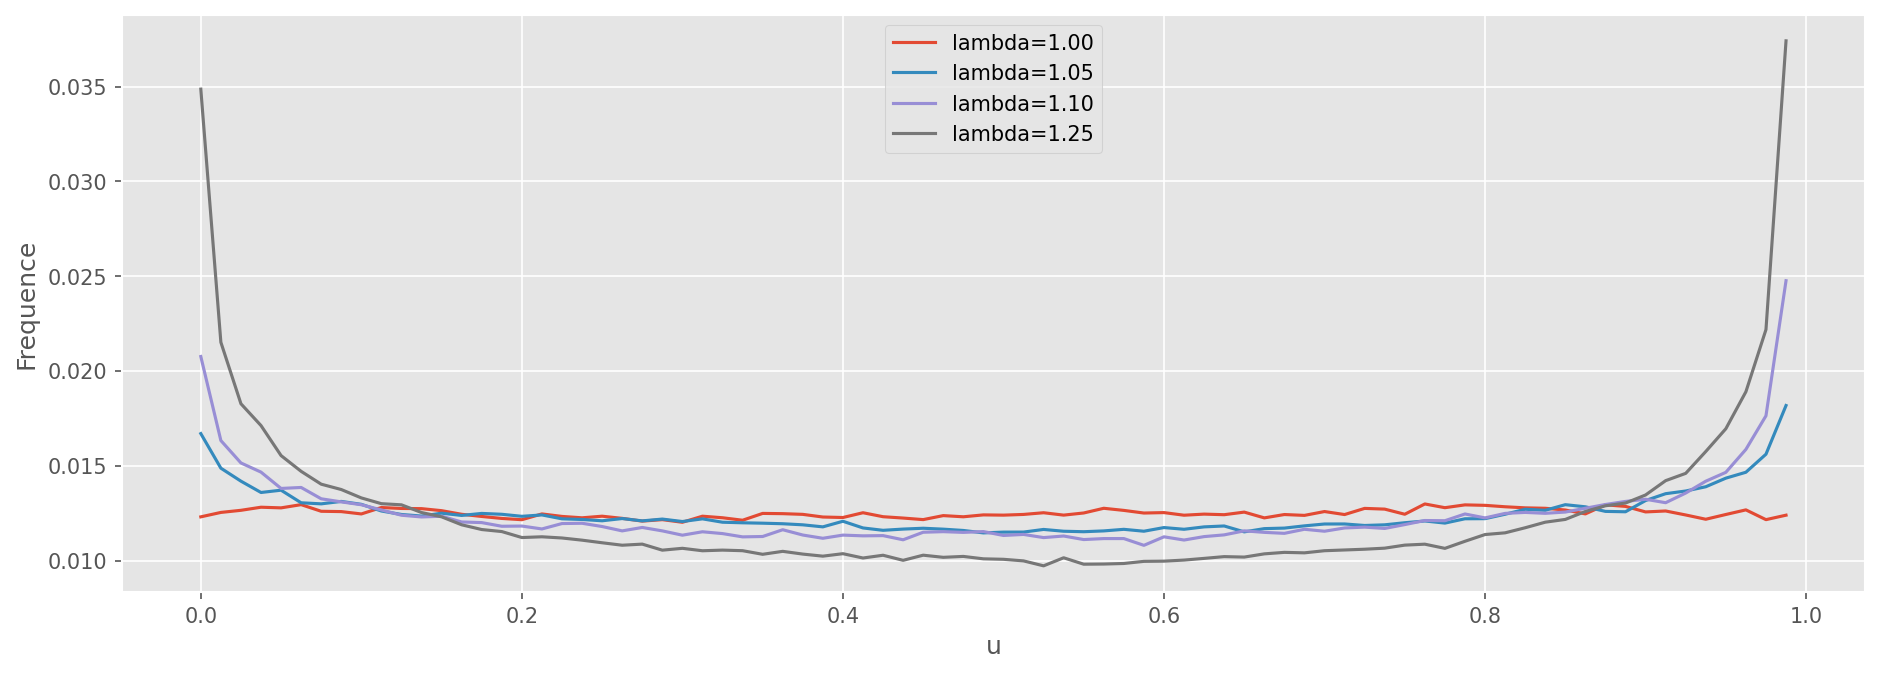

In [11]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)

step_ = 81
density_sample_dataframe(u_df_2501_one_nonsort, step_).plot(ax=ax, label="lambda=1.00")
density_sample_dataframe(u_df_2501_two_nonsort, step_).plot(ax=ax, label="lambda=1.05")
density_sample_dataframe(u_df_2501_three_nonsort, step_).plot(ax=ax, label="lambda=1.10")
density_sample_dataframe(u_df_2501_forth_nonsort, step_).plot(ax=ax, label="lambda=1.25")

ax.set_xlabel("u")
ax.set_ylabel("Frequence")
ax.legend()

## Statistics

### Kolmogorov-Smirnov

Далее приведем примеры графиков плотности статистики для параметров $h = 1$ и $d = 1$(т.е. для наблюдений без пересечений) в модели. Подставляем в статистику уже отсортированные равномерные значения.

In [12]:
def KolmogorovSmirnov(date : pd.DataFrame) -> pd.Series:
    D_plus = (np.arange(1, date.shape[0] + 1)/date.shape[0] - date.T).T.max()
    D_minus = (date.T - np.arange(date.shape[0])/date.shape[0]).T.max()
    
    ks_value = pd.DataFrame([D_plus, D_minus]).max(axis=0)

    return ks_value

In [13]:
test_1 = u_df_11_one_nonsort.copy()
test_2 = u_df_11_two_nonsort.copy()
test_3 = u_df_11_three_nonsort.copy()
test_4 = u_df_11_forth_nonsort.copy()

In [14]:
step_ = 1001

df_ks_one = density_sample_series(KolmogorovSmirnov(sort_table_by_column(test_1)), step_)
df_ks_two = density_sample_series(KolmogorovSmirnov(sort_table_by_column(test_2)), step_)
df_ks_three = density_sample_series(KolmogorovSmirnov(sort_table_by_column(test_3)), step_)
df_ks_forth = density_sample_series(KolmogorovSmirnov(sort_table_by_column(test_4)), step_)

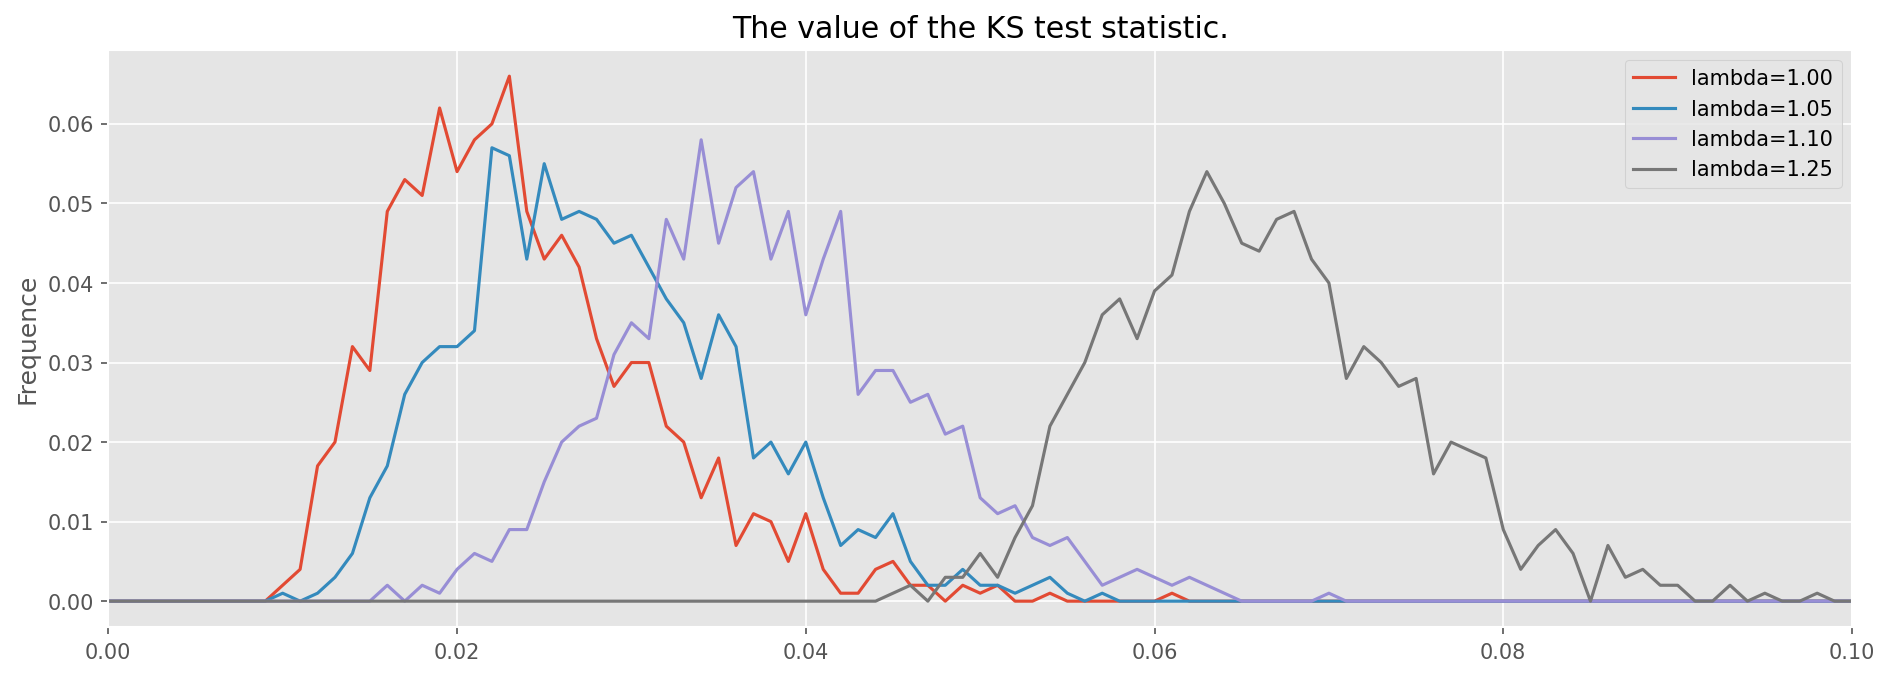

In [15]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)

df_ks_one.plot(ax=ax, label="lambda=1.00")
df_ks_two.plot(ax=ax, label="lambda=1.05")
df_ks_three.plot(ax=ax, label="lambda=1.10")
df_ks_forth.plot(ax=ax, label="lambda=1.25")

ax.set_title("The value of the KS test statistic.")
ax.set_ylabel("Frequence")
ax.legend()
ax.set_xlim(0, 0.1)
plt.show()

### Anderson-Darling

In [16]:
def AndersonDarling(date : pd.DataFrame):
    temp = date.copy()
    temp[temp == 0.0] = 1e-15
    temp_df_first = temp.apply(lambda x : np.log(x))
    temp_df_first = temp_df_first.mul(2*np.arange(1, temp_df_first.shape[0] + 1) - 1, axis=0)

    temp = date.copy()
    temp[temp == 1.0] = 1 - 1e-15
    temp_df_second = (1 - temp).apply(lambda x : np.log(x))
    temp_df_second = temp_df_second.mul(2*(temp_df_second.shape[0] - np.arange(1, temp_df_second.shape[0] + 1)) + 1, axis=0)

    ad_value = - temp_df_second.shape[0] - (1/temp_df_second.shape[0])*((temp_df_first + temp_df_second).sum(axis=0))

    return ad_value

In [17]:
test_1 = u_df_11_one_nonsort.copy()
test_2 = u_df_11_two_nonsort.copy()
test_3 = u_df_11_three_nonsort.copy()
test_4 = u_df_11_forth_nonsort.copy()

In [18]:
step_ = 250

df_ad_one = density_sample_series(AndersonDarling(sort_table_by_column(test_1)), step_)
df_ad_two = density_sample_series(AndersonDarling(sort_table_by_column(test_2)), step_)
df_ad_three = density_sample_series(AndersonDarling(sort_table_by_column(test_3)), step_)
df_ad_forth = density_sample_series(AndersonDarling(sort_table_by_column(test_4)), step_)

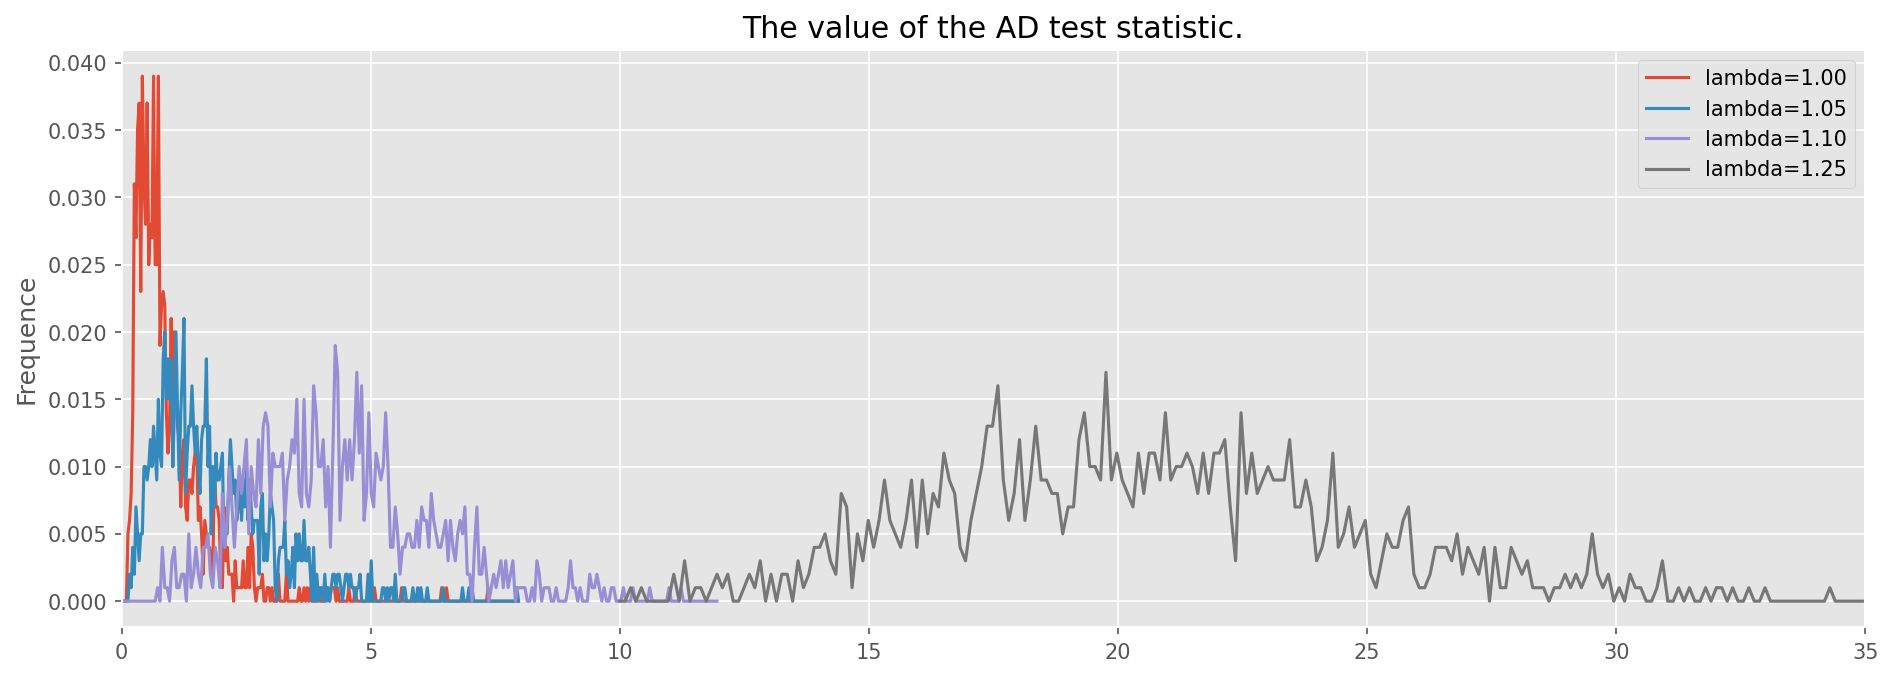

In [19]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)

df_ad_one.plot(ax=ax, label="lambda=1.00")
df_ad_two.plot(ax=ax, label="lambda=1.05")
df_ad_three.plot(ax=ax, label="lambda=1.10")
df_ad_forth.plot(ax=ax, label="lambda=1.25")

ax.set_title("The value of the AD test statistic.")
ax.set_ylabel("Frequence")
ax.legend()
ax.set_xlim(0, 35)
plt.show()

### Likelihood Ratio

In [20]:
def LikelihoodRatio(z_values : pd.DataFrame):
    temp_df = (1/z_values.shape[0])*((z_values**2).sum(axis=0)) - ((1/z_values.shape[0])*(z_values.sum(axis=0)))**2
    temp_df_log = temp_df.map(lambda x : np.log(x))

    lr_value = -temp_df.shape[0]*(1 - temp_df + temp_df_log)

    return lr_value

In [21]:
test_1 = z_df_11_one_nonsort.copy()
test_2 = z_df_11_two_nonsort.copy()
test_3 = z_df_11_three_nonsort.copy()
test_4 = z_df_11_forth_nonsort.copy()

In [22]:
step_ = 150

df_lr_one = density_sample_series(LikelihoodRatio(test_1),step_)
df_lr_two = density_sample_series(LikelihoodRatio(test_2), step_)
df_lr_three = density_sample_series(LikelihoodRatio(test_3), step_)
df_lr_forth = density_sample_series(LikelihoodRatio(test_4), step_)

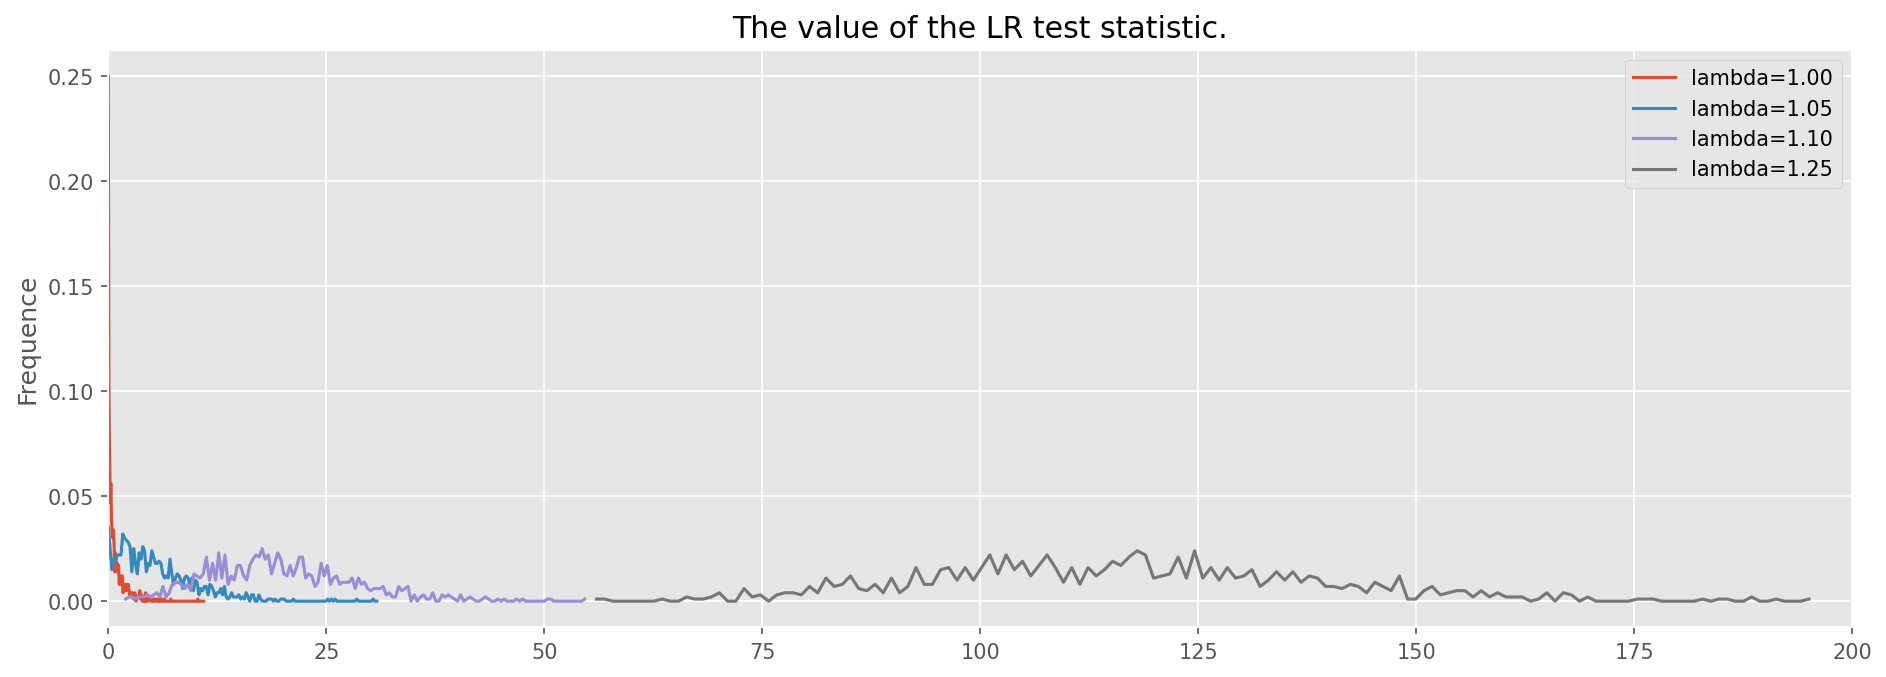

In [23]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)

df_lr_one.plot(ax=ax, label="lambda=1.00")
df_lr_two.plot(ax=ax, label="lambda=1.05")
df_lr_three.plot(ax=ax, label="lambda=1.10")
df_lr_forth.plot(ax=ax, label="lambda=1.25")


ax.set_title("The value of the LR test statistic.")
ax.set_ylabel("Frequence")
ax.set_xlim(0, 200)
ax.legend()
plt.show()


## Discriminatory Power

In [24]:
test_1 = u_df_11_one_nonsort.copy()
test_2 = u_df_11_two_nonsort.copy()
test_3 = u_df_11_three_nonsort.copy()
test_4 = u_df_11_forth_nonsort.copy()

z_test_1 = z_df_11_one_nonsort.copy()
z_test_2 = z_df_11_two_nonsort.copy()
z_test_3 = z_df_11_three_nonsort.copy()
z_test_4 = z_df_11_forth_nonsort.copy()

test_df_ad_one = AndersonDarling(sort_table_by_column(test_1))
test_df_ad_two = AndersonDarling(sort_table_by_column(test_2))
test_df_ad_three = AndersonDarling(sort_table_by_column(test_3))
test_df_ad_forth = AndersonDarling(sort_table_by_column(test_4))

test_df_ks_one = KolmogorovSmirnov(sort_table_by_column(test_1))
test_df_ks_two = KolmogorovSmirnov(sort_table_by_column(test_2))
test_df_ks_three = KolmogorovSmirnov(sort_table_by_column(test_3))
test_df_ks_forth = KolmogorovSmirnov(sort_table_by_column(test_4))

test_df_lr_one = LikelihoodRatio(z_test_1)
test_df_lr_two = LikelihoodRatio(z_test_2)
test_df_lr_three = LikelihoodRatio(z_test_3)
test_df_lr_forth = LikelihoodRatio(z_test_4)

In [25]:
def make_cumulitive_ditrib(data: pd.DataFrame):
    """Make cumsum distribution and normalize ox to [0,1]
    """
    x = data.sort_values(ignore_index=True).to_numpy()
    N = x.shape[0]
    y = np.arange(N) / float(N)
    result = pd.DataFrame([x, y]).T
    result.columns = ["ox", "oy"]

    return result

In [26]:
def get_TPR(data_benchmark: pd.DataFrame, data_statistic: pd.DataFrame) -> pd.DataFrame:
    """Make frame with TPR value (see formule 3.3)
    """
    TPR_curve = {}
    step_for_range = 101
    p_range = np.linspace(0, 1, step_for_range)
    for p_value in p_range:
        revers_p_value = data_benchmark.loc[(data_benchmark["oy"] - p_value).abs().sort_values().head(1).index[0], "ox"]
        get_final_p_value = None
        if revers_p_value >= data_statistic["ox"].iloc[-1]:
            get_final_p_value = 1
        elif revers_p_value <= data_statistic["ox"].iloc[0]:
            get_final_p_value = 0
        else:
            get_final_p_value = data_statistic.loc[(data_statistic["ox"] - revers_p_value).abs().sort_values().head(1).index[0], "oy"]
        TPR_curve[1 - p_value] = 1 - get_final_p_value

    return pd.DataFrame(TPR_curve.items())

In [27]:
def plot_TPR(data_benchmark_ks: pd.DataFrame, data_benchmark_ad: pd.DataFrame, data_benchmark_lr: pd.DataFrame,
             data_ks: pd.DataFrame, data_ad: pd.DataFrame, data_lr: pd.DataFrame, 
             lambda_ : str, days_info: str, is_overlap: str):
    """Plot True Positive Rate graphics for all statistics(KS, AD, LR)
    
    Args:
        data_benchmark_ks : value of KS statistics
    """
    df_null_model_ks_cumsum = make_cumulitive_ditrib(data_benchmark_ks)
    df_null_model_ad_cumsum = make_cumulitive_ditrib(data_benchmark_ad)
    df_null_model_lr_cumsum = make_cumulitive_ditrib(data_benchmark_lr)
    df_ks_cumsum = make_cumulitive_ditrib(data_ks)
    df_ad_cumsum = make_cumulitive_ditrib(data_ad)
    df_lr_cumsum = make_cumulitive_ditrib(data_lr)

    _, ax = plt.subplots(figsize=(4, 4), dpi=150)

    plot_TPR_ks = get_TPR(df_null_model_ks_cumsum, df_ks_cumsum)
    plot_TPR_ad = get_TPR(df_null_model_ad_cumsum, df_ad_cumsum)
    plot_TPR_lr = get_TPR(df_null_model_lr_cumsum, df_lr_cumsum)

    linear_func = np.linspace(0, 1, 2)
    ax.plot(linear_func, linear_func, label="No Disc.")
    plot_TPR_ks.plot(ax=ax, x=0, y=1, label="KS")
    plot_TPR_ad.plot(ax=ax, x=0, y=1, label="AD")
    plot_TPR_lr.plot(ax=ax, x=0, y=1, label="LR")

    ax.set_title("The TPR curve for the {}-day, {} backtest experiment, with λ = {}.".format(days_info, is_overlap, lambda_), fontsize=6)
    ax.set_ylabel("True Positive Rate", fontsize=6)
    ax.set_xlabel("False Positive Rate", fontsize=6)

    ax.legend()
    plt.show()

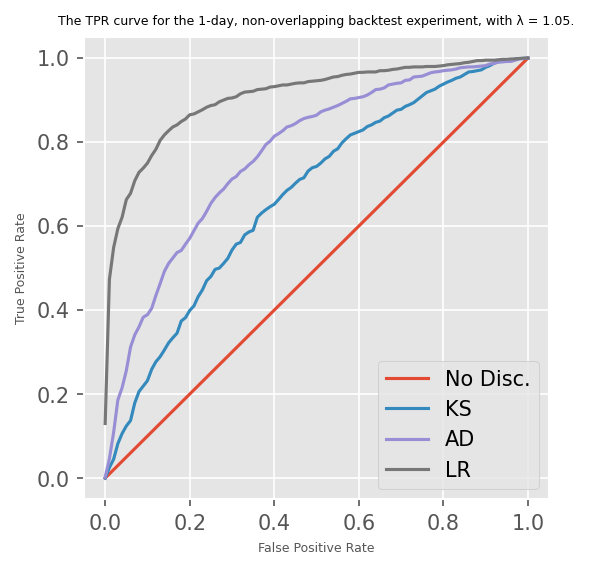

In [28]:
plot_TPR(test_df_ks_one, test_df_ad_one, test_df_lr_one, test_df_ks_two, test_df_ad_two, test_df_lr_two, 
        "1.05", "1", "non-overlapping")

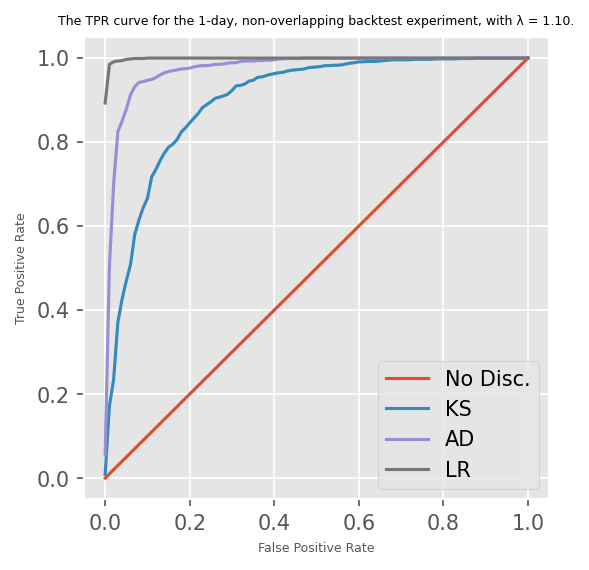

In [29]:
plot_TPR(test_df_ks_one, test_df_ad_one, test_df_lr_one, test_df_ks_three, test_df_ad_three, test_df_lr_three, 
        "1.10", "1", "non-overlapping")

## 10-day NON-OVERLAPPING

Теперь приведем примеры графиков плотности статистики для параметров $h = 10$ и $d = 10$(т.е. для наблюдений без пересечений) в модели.

In [30]:
def plot_all_statistics(test_df_ks_one, test_df_ks_two, test_df_ks_three, test_df_ks_forth,
                        test_df_ad_one, test_df_ad_two, test_df_ad_three, test_df_ad_forth,
                        test_df_lr_one, test_df_lr_two, test_df_lr_three, test_df_lr_forth):
    _, ax = plt.subplots(nrows=3, figsize=(15, 10), dpi=150)

    # KS
    step_ = 1001

    density_sample_series(test_df_ks_one, step_).plot(ax=ax[0], label="lambda=1.00")
    density_sample_series(test_df_ks_two, step_).plot(ax=ax[0], label="lambda=1.05")
    density_sample_series(test_df_ks_three, step_).plot(ax=ax[0], label="lambda=1.10")
    density_sample_series(test_df_ks_forth, step_).plot(ax=ax[0], label="lambda=1.25")

    ax[0].set_title("The value of the KS test statistic.")
    ax[0].set_ylabel("Frequence")
    ax[0].legend()
    # ax[0].set_xlim(0.25, 0.5)

    # AD
    step_ = 250


    density_sample_series(test_df_ad_one, step_).plot(ax=ax[1], label="lambda=1.00")
    density_sample_series(test_df_ad_two, step_).plot(ax=ax[1], label="lambda=1.05")
    density_sample_series(test_df_ad_three, step_).plot(ax=ax[1], label="lambda=1.10")
    density_sample_series(test_df_ad_forth, step_).plot(ax=ax[1], label="lambda=1.25")


    ax[1].set_title("The value of the AD test statistic.")
    ax[1].set_ylabel("Frequence")
    ax[1].legend()
    # ax[1].set_xlim(0, right_ad)

    # LR
    step_ = 150


    density_sample_series(test_df_lr_one, step_).plot(ax=ax[2], label="lambda=1.00")
    density_sample_series(test_df_lr_two, step_).plot(ax=ax[2], label="lambda=1.05")
    density_sample_series(test_df_lr_three, step_).plot(ax=ax[2], label="lambda=1.10")
    density_sample_series(test_df_lr_forth, step_).plot(ax=ax[2], label="lambda=1.25")

    ax[2].set_title("The value of the LR test statistic.")
    ax[2].set_ylabel("Frequence")
    ax[2].legend()
    # ax[2].set_xlim(0, right_lr)

    plt.show()
    

In [31]:
test_1 = u_df_1010_one_nonsort.copy()
test_2 = u_df_1010_two_nonsort.copy()
test_3 = u_df_1010_three_nonsort.copy()
test_4 = u_df_1010_forth_nonsort.copy()

z_test_1 = z_df_1010_one_nonsort.copy()
z_test_2 = z_df_1010_two_nonsort.copy()
z_test_3 = z_df_1010_three_nonsort.copy()
z_test_4 = z_df_1010_forth_nonsort.copy()

test_df_ad_one = AndersonDarling(sort_table_by_column(test_1))
test_df_ad_two = AndersonDarling(sort_table_by_column(test_2))
test_df_ad_three = AndersonDarling(sort_table_by_column(test_3))
test_df_ad_forth = AndersonDarling(sort_table_by_column(test_4))

test_df_ks_one = KolmogorovSmirnov(sort_table_by_column(test_1))
test_df_ks_two = KolmogorovSmirnov(sort_table_by_column(test_2))
test_df_ks_three = KolmogorovSmirnov(sort_table_by_column(test_3))
test_df_ks_forth = KolmogorovSmirnov(sort_table_by_column(test_4))

test_df_lr_one = LikelihoodRatio(z_test_1)
test_df_lr_two = LikelihoodRatio(z_test_2)
test_df_lr_three = LikelihoodRatio(z_test_3)
test_df_lr_forth = LikelihoodRatio(z_test_4)

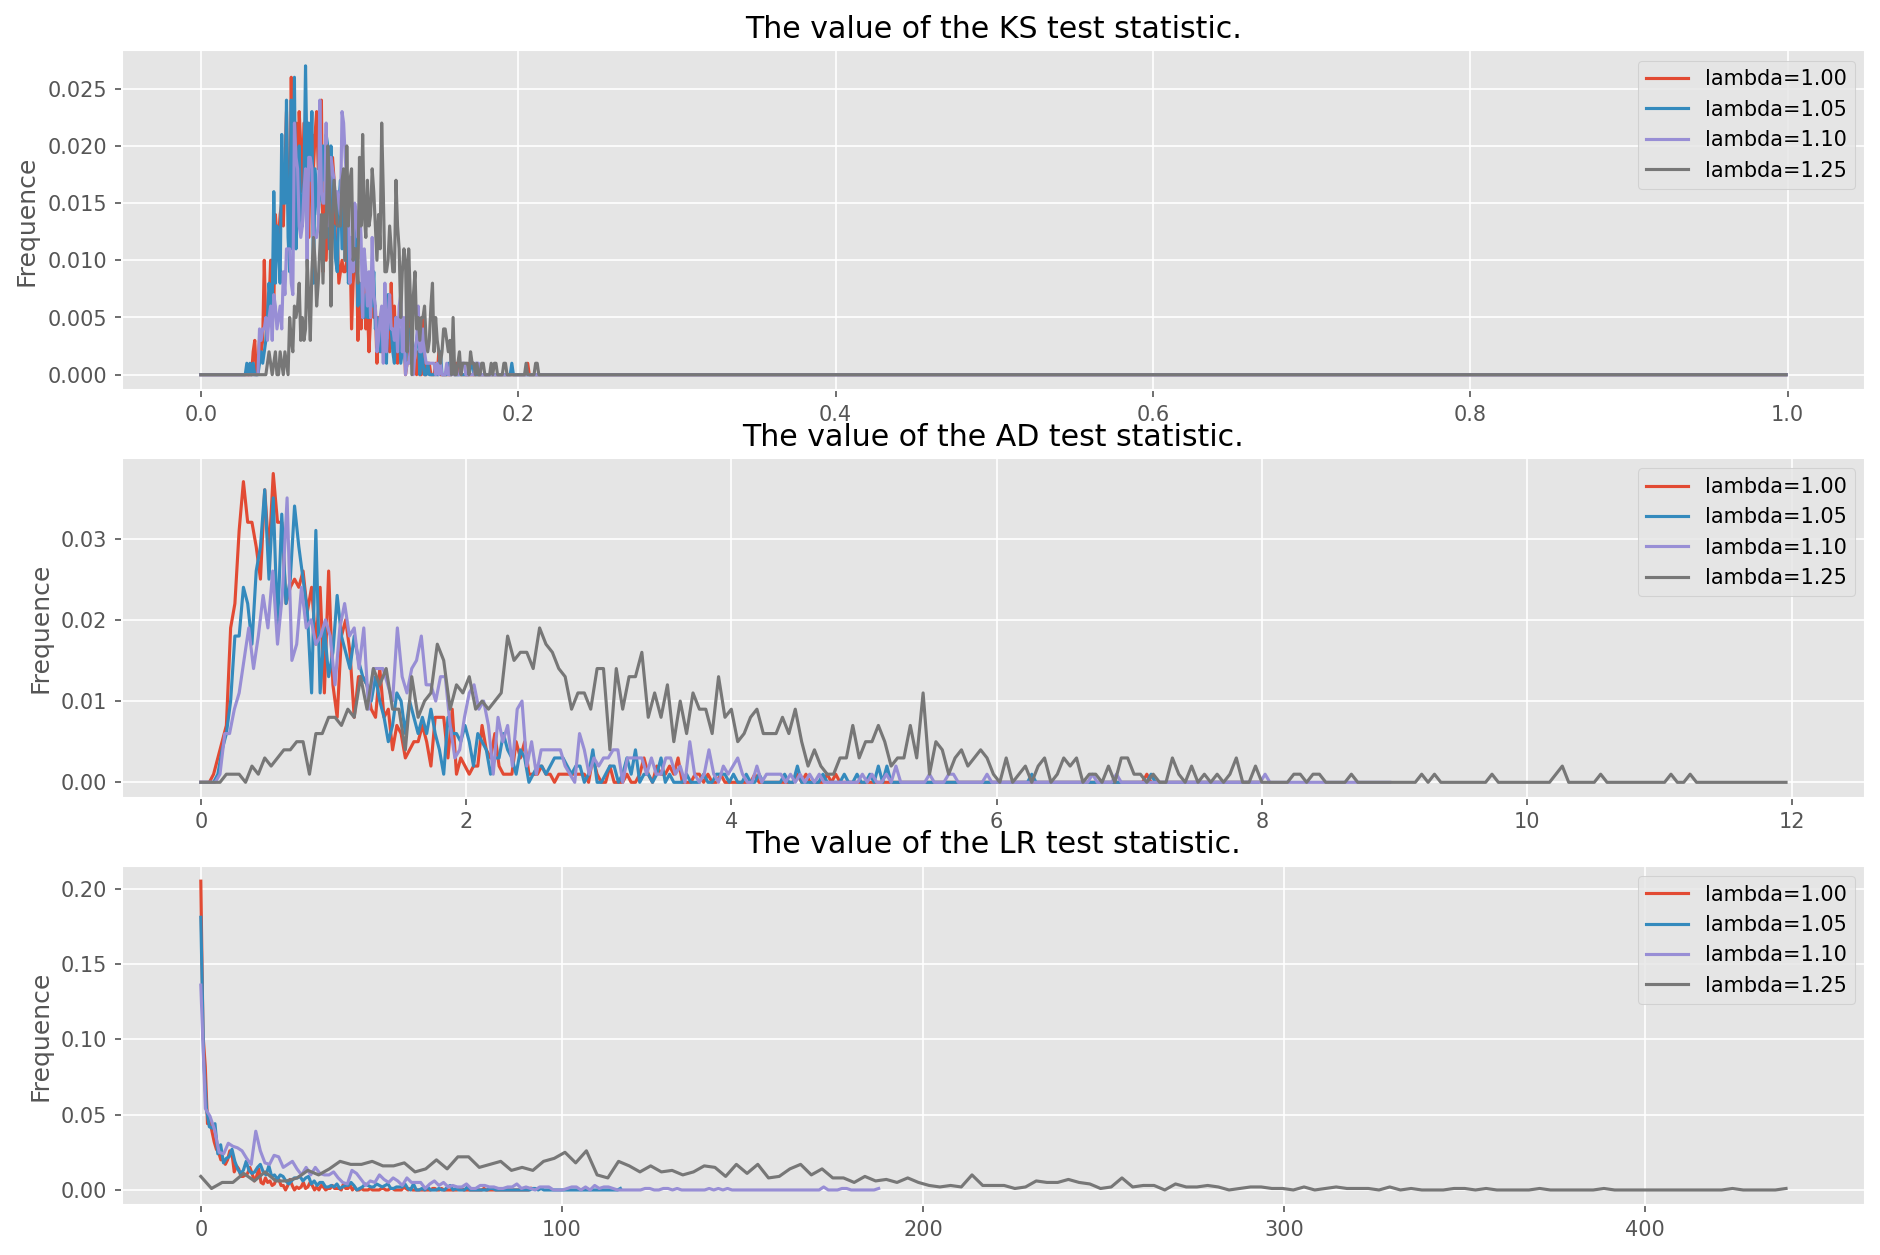

In [32]:
plot_all_statistics(test_df_ks_one, test_df_ks_two, test_df_ks_three, test_df_ks_forth,
                    test_df_ad_one, test_df_ad_two, test_df_ad_three, test_df_ad_forth, 
                    test_df_lr_one, test_df_lr_two, test_df_lr_three, test_df_lr_forth)

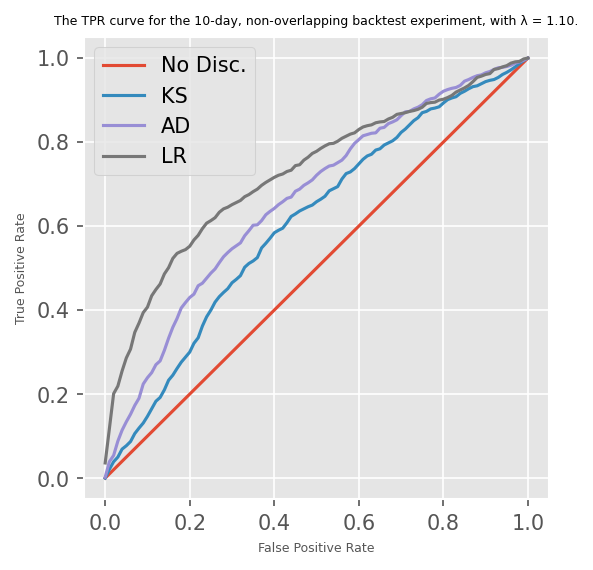

In [33]:
plot_TPR(test_df_ks_one, test_df_ad_one, test_df_lr_one, test_df_ks_three, test_df_ad_three, test_df_lr_three,
          "1.10", "10", "non-overlapping")

## 250-day OVERLAPPING

Далее приведем примеры графиков плотности статистики для параметров $h = 250$ и $d = 1$(т.е. для наблюдений с пересечениями) в модели.

In [34]:
test_1 = u_df_2501_one_nonsort.copy()
test_2 = u_df_2501_two_nonsort.copy()
test_3 = u_df_2501_three_nonsort.copy()
test_4 = u_df_2501_forth_nonsort.copy()

z_test_1 = z_df_2501_one_nonsort.copy()
z_test_2 = z_df_2501_two_nonsort.copy()
z_test_3 = z_df_2501_three_nonsort.copy()
z_test_4 = z_df_2501_forth_nonsort.copy()

test_df_ad_one = AndersonDarling(sort_table_by_column(test_1))
test_df_ad_two = AndersonDarling(sort_table_by_column(test_2))
test_df_ad_three = AndersonDarling(sort_table_by_column(test_3))
test_df_ad_forth = AndersonDarling(sort_table_by_column(test_4))

test_df_ks_one = KolmogorovSmirnov(sort_table_by_column(test_1))
test_df_ks_two = KolmogorovSmirnov(sort_table_by_column(test_2))
test_df_ks_three = KolmogorovSmirnov(sort_table_by_column(test_3))
test_df_ks_forth = KolmogorovSmirnov(sort_table_by_column(test_4))

test_df_lr_one = LikelihoodRatio(z_test_1)
test_df_lr_two = LikelihoodRatio(z_test_2)
test_df_lr_three = LikelihoodRatio(z_test_3)
test_df_lr_forth = LikelihoodRatio(z_test_4)

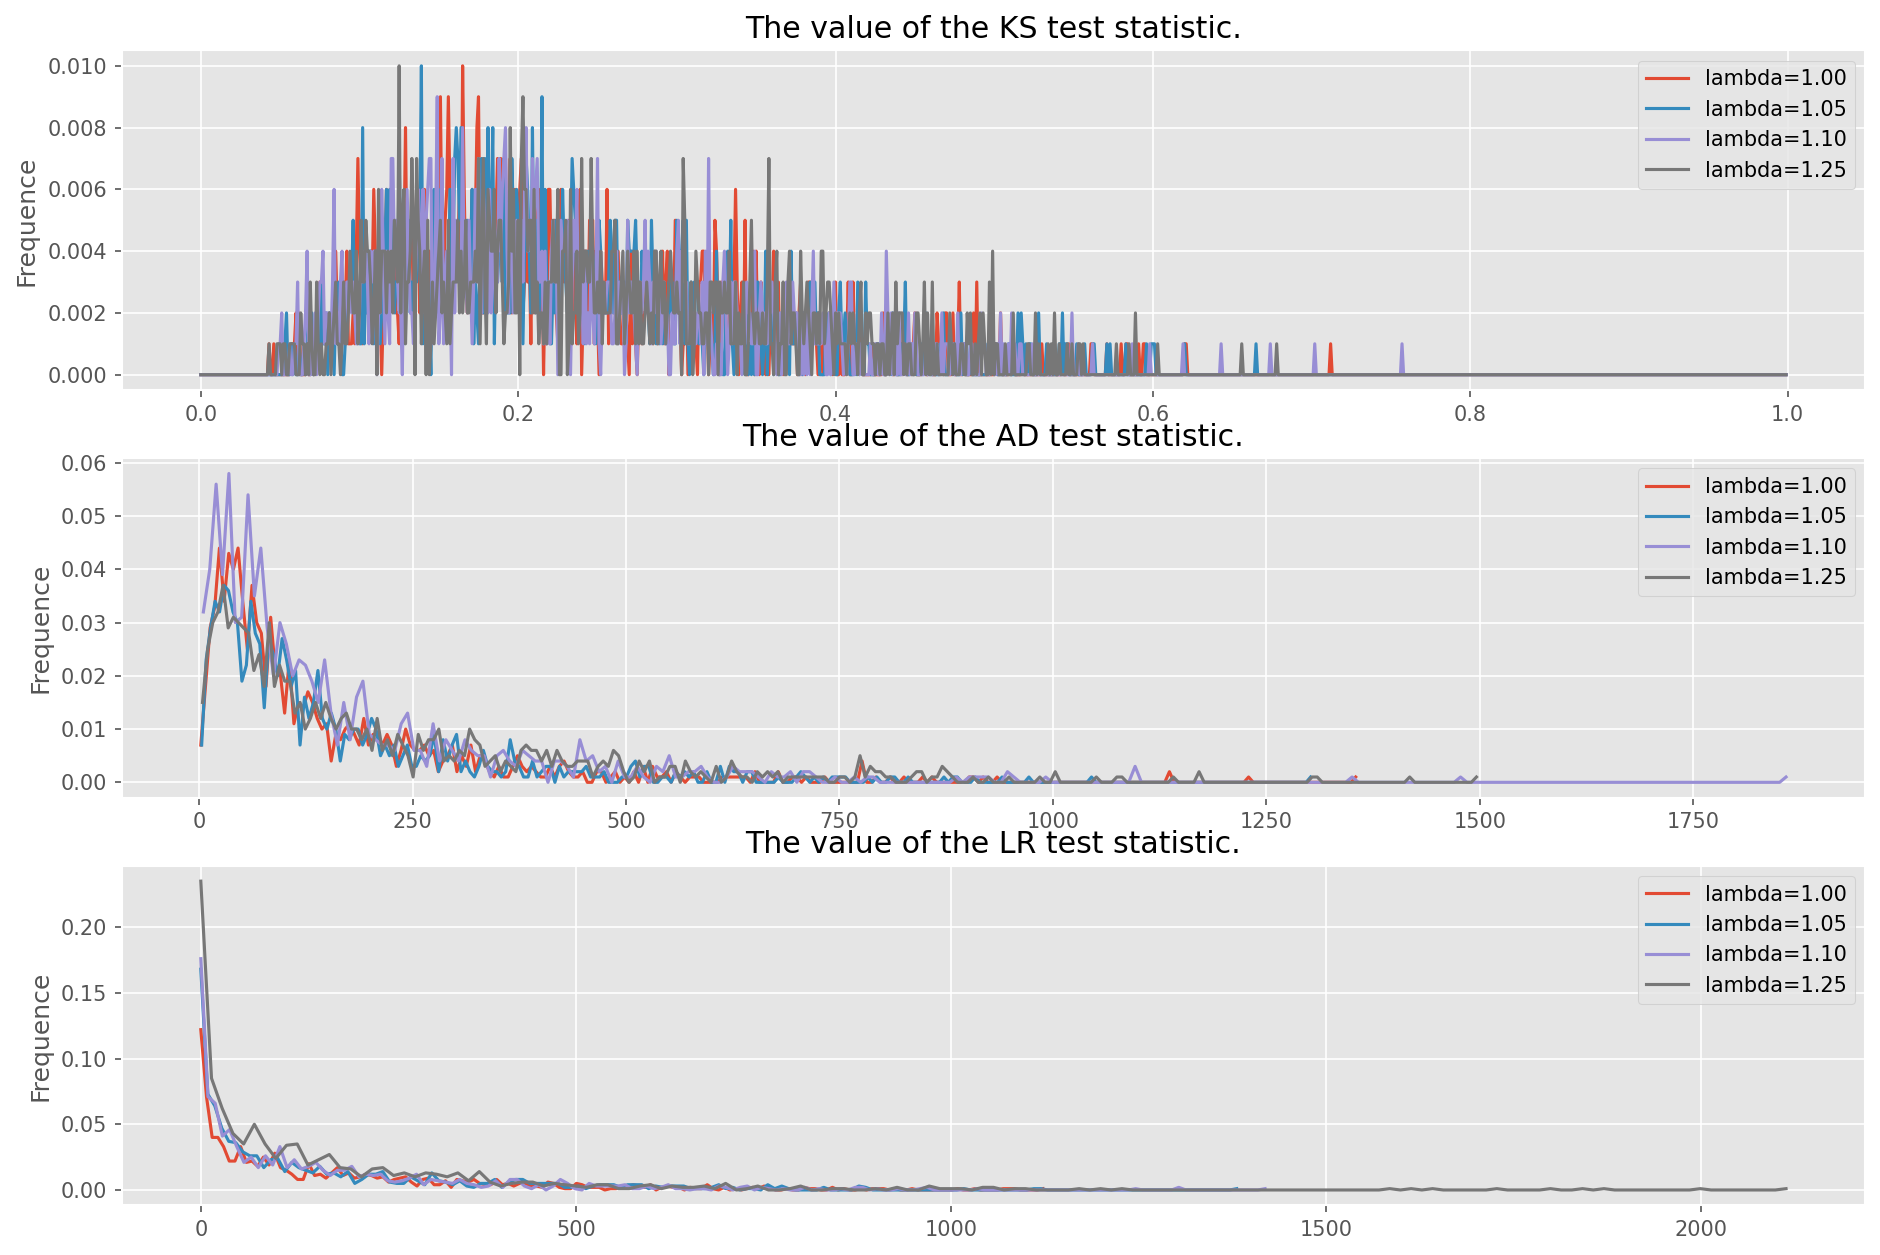

In [35]:
plot_all_statistics(test_df_ks_one, test_df_ks_two, test_df_ks_three, test_df_ks_forth,
                    test_df_ad_one, test_df_ad_two, test_df_ad_three, test_df_ad_forth, 
                    test_df_lr_one, test_df_lr_two, test_df_lr_three, test_df_lr_forth,)

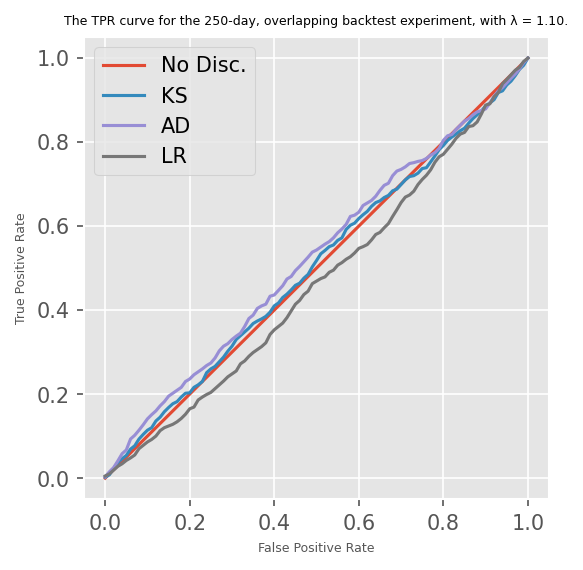

In [36]:
plot_TPR(test_df_ks_one, test_df_ad_one, test_df_lr_one, test_df_ks_three, test_df_ad_three, test_df_lr_three, "1.10", "250", "overlapping")

## Modified Tests Statistics for Overlapping Observations

In [37]:
n_paths = 1000
N_obs = 1251
h = 250
d = 1
n_steps = int(np.round(((N_obs - 1 - h) / d) + 1))
lambda_one = 1.00
lambda_two = 1.05
lambda_three = 1.10
lambda_forth = 1.25
sigma = 1.

### Modified Kolmogorov-Smirnov

In [38]:
test_1 = z_df_2501_one_nonsort.copy()
test_3 = z_df_2501_three_nonsort.copy()

eigenvalues, eigenvectors = np.linalg.eig(covariation_matrix(d, h, n_steps))

In [39]:
def KolmogorovSmirnovModified(z_values: pd.DataFrame, eigenvalues: np.ndarray, eigenvectors: np.ndarray):
    eigenvalues =  1.0 / np.sqrt(eigenvalues)

    decorrelated_u_value = pd.DataFrame()
    for i in range(z_values.shape[1]):
        temp = (z_values.iloc[:, i].to_numpy() @ eigenvectors) * eigenvalues
        decorrelated_u_value[i] = pd.Series(scipy.stats.norm.cdf(temp))
    
    # print(decorrelated_u_value)
    # decorrelated_z_value = (eigenvectors @ z_values.to_numpy()) 
    # decorrelated_z_value = decorrelated_z_value * eigenvalues.reshape(len(eigenvalues), 1)
    # decorrelated_u_value = scipy.stats.norm.cdf(decorrelated_z_value)


    ks_value = KolmogorovSmirnov(sort_table_by_column(decorrelated_u_value))
    return ks_value

In [40]:
test_df_ks_one = KolmogorovSmirnovModified(test_1.iloc[:, :100], eigenvalues, eigenvectors)
test_df_ks_three = KolmogorovSmirnovModified(test_3.iloc[:, :100], eigenvalues, eigenvectors)

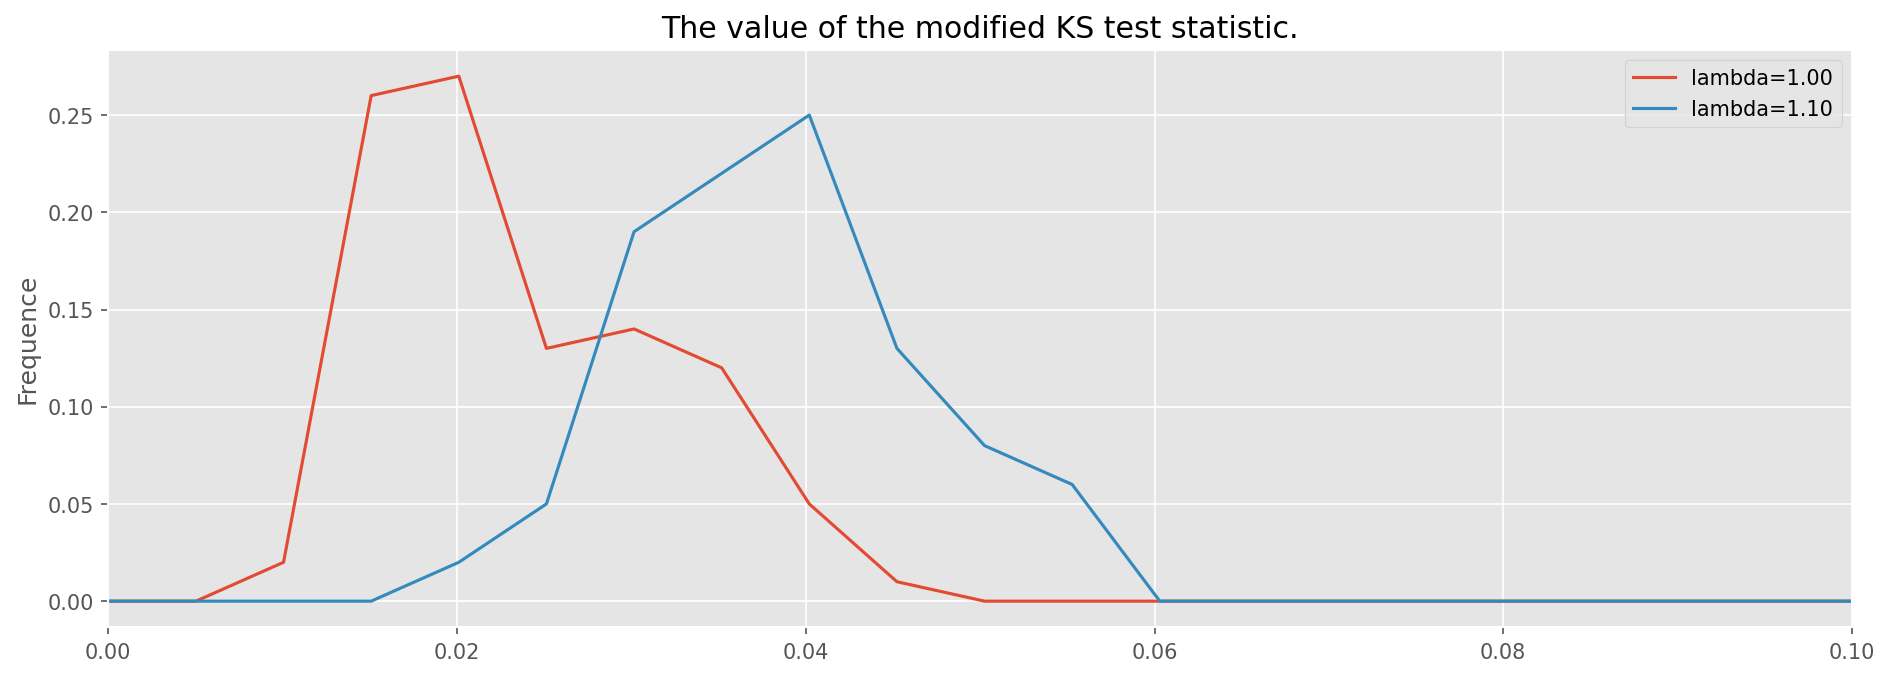

In [41]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)

steps_ = 200

density_sample_series(test_df_ks_one, steps_).plot(ax=ax, label="lambda=1.00")
density_sample_series(test_df_ks_three, steps_).plot(ax=ax, label="lambda=1.10")


ax.set_title("The value of the modified KS test statistic.")
ax.set_ylabel("Frequence")
ax.legend()
ax.set_xlim(0, 0.1)
plt.show()

### Modified Anderson-Darling

In [42]:
test_1 = z_df_2501_one_nonsort.copy()
test_3 = z_df_2501_three_nonsort.copy()

eigenvalues, eigenvectors = np.linalg.eig(covariation_matrix(d, h, n_steps))

In [43]:
def AndersonDarlingModified(z_values: pd.DataFrame, eigenvalues: np.ndarray, eigenvectors: np.ndarray):
    eigenvalues =  1.0 / np.sqrt(eigenvalues)

    decorrelated_u_value = pd.DataFrame()
    for i in range(z_values.shape[1]):
        temp = (z_values.iloc[:, i].to_numpy() @ eigenvectors) * eigenvalues
        decorrelated_u_value[i] = pd.Series(scipy.stats.norm.cdf(temp))

    # decorrelated_z_value = eigenvectors.reset_index(drop=True) @ z_values.reset_index(drop=True)
    # decorrelated_z_value = decorrelated_z_value.mul(eigenvalues.to_numpy(), axis=0)
    # decorrelated_u_value = decorrelated_z_value.applymap(stats.norm.cdf)

    ad_value = AndersonDarling(sort_table_by_column(decorrelated_u_value))

    return ad_value

In [44]:
test_df_ad_one = AndersonDarlingModified(test_1.iloc[:, :100], eigenvalues, eigenvectors)
test_df_ad_three = AndersonDarlingModified(test_3.iloc[:, :100], eigenvalues, eigenvectors)

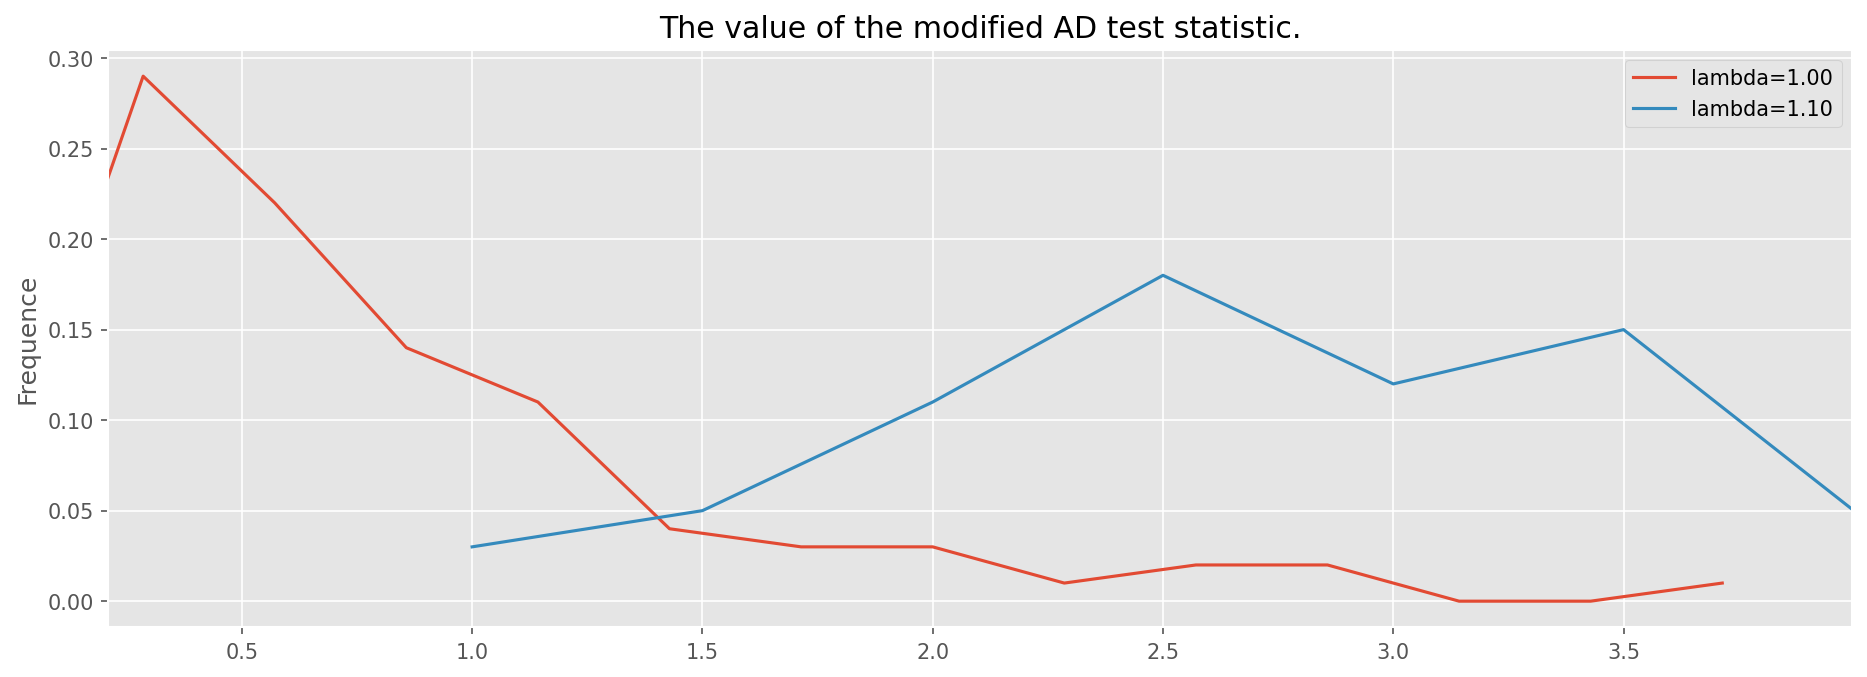

In [45]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)

steps_ = 15
density_sample_series(test_df_ad_one, steps_).plot(ax=ax, label="lambda=1.00")
density_sample_series(test_df_ad_three, steps_).plot(ax=ax, label="lambda=1.10")


ax.set_title("The value of the modified AD test statistic.")
ax.set_ylabel("Frequence")
ax.legend()
ax.set_xlim(test_df_ad_one.min(), test_df_ad_one.max())
plt.show()

### Modified Likelihood

In [46]:
N_obs = 1251
h = 250
d = 1
n_steps = int(np.round(((N_obs - 1 - h) / d) + 1))

test_1 = z_df_2501_one_nonsort.copy()
test_3 = z_df_2501_three_nonsort.copy()

invese_matrix = np.linalg.inv(covariation_matrix(d, h, n_steps))

In [47]:
def LikelihoodRatioModified(z_values : pd.DataFrame, invese_matrix: np.ndarray) -> pd.Series:
    # invese_matrix = pd.DataFrame(invese_matrix).transpose()
    lr_value = []

    for i in z_values.columns:
        # estimating_mean = invese_matrix.mul(date.loc[:, i]).sum().sum() / invese_matrix.sum().sum()
        # estimating_var = (1 / date.shape[0]) * invese_matrix.mul(date.loc[:, i] - estimating_mean).mul(date.loc[:, i] - estimating_mean, axis='index').sum().sum()
        # if estimating_var == 0.0:
        #     estimating_var = 1e-15
        # lr_value.append(-date.shape[0]*(1 - estimating_var + np.log(estimating_var)))

        z_series = z_values.loc[:, i].to_numpy()
        estimating_mean : float = np.multiply(invese_matrix, z_series).sum() / invese_matrix.sum()

        temp_matrix : np.ndarray = invese_matrix * (z_series - estimating_mean)
        temp_matrix : np.ndarray = temp_matrix * (z_series - estimating_mean).reshape(-1, 1)
        estimating_var : float = (1 / z_values.shape[0]) * temp_matrix.sum()
        
        if estimating_var == 0.0:
            estimating_var = 1e-15
        lr_value.append(-z_values.shape[0]*(1 - estimating_var + np.log(estimating_var)))

    return pd.Series(lr_value)

In [48]:
test_df_lr_one = LikelihoodRatioModified(test_1.iloc[:, :100], invese_matrix)
test_df_lr_three = LikelihoodRatioModified(test_3.iloc[:, :100], invese_matrix)

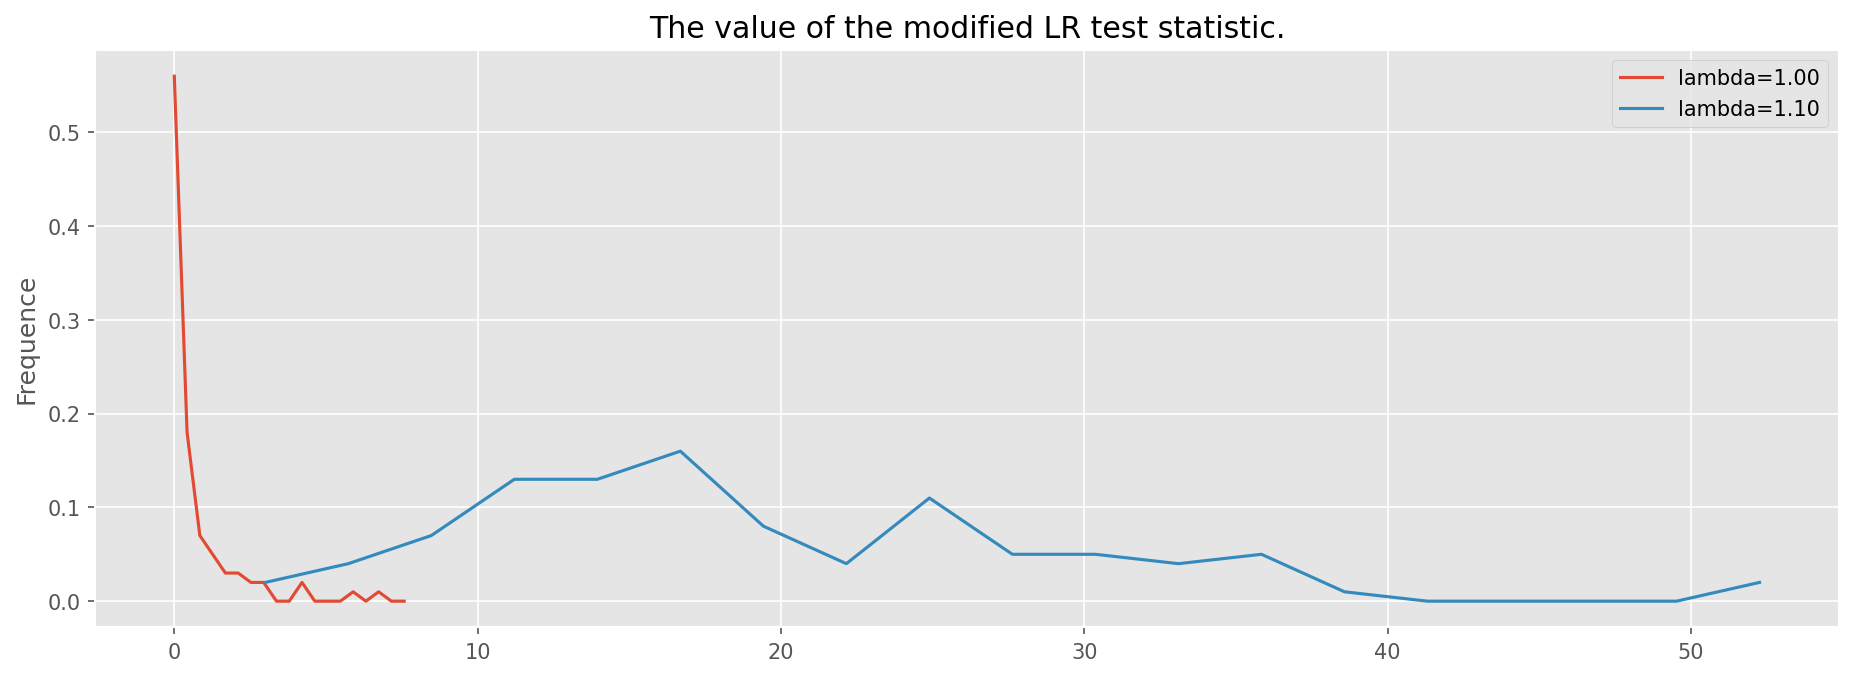

In [49]:
_, ax = plt.subplots(figsize=(15, 5), dpi=150)

steps_ = 20
density_sample_series(test_df_lr_one, steps_).plot(ax=ax, label="lambda=1.00")
density_sample_series(test_df_lr_three, steps_).plot(ax=ax, label="lambda=1.10")


ax.set_title("The value of the modified LR test statistic.")
ax.set_ylabel("Frequence")
ax.legend()
# ax.set_xlim(test_df_lr_one.min(), test_df_lr_one.max())
plt.show()

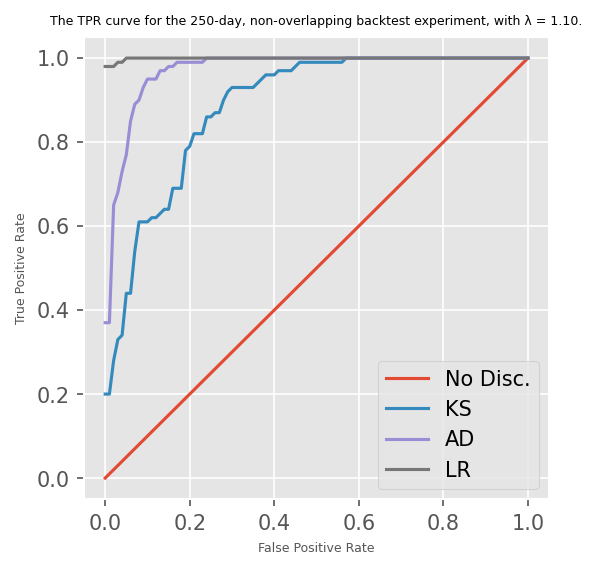

In [50]:
plot_TPR(test_df_ks_one, test_df_ad_one, test_df_lr_one, 
         test_df_ks_three, test_df_ad_three, test_df_lr_three, 
        "1.10", "250", "non-overlapping")